# Imports

In [1]:
import torch
import torchvision
import torchvision.models as models
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from PIL import Image
import os
import numpy as np
from scipy.io import loadmat
import cv2

# from extract_features import extract_features
# from check_webers_law import check_webers_law
# from layerwise_mi_figures import layerwise_mi_figures


# Dataset

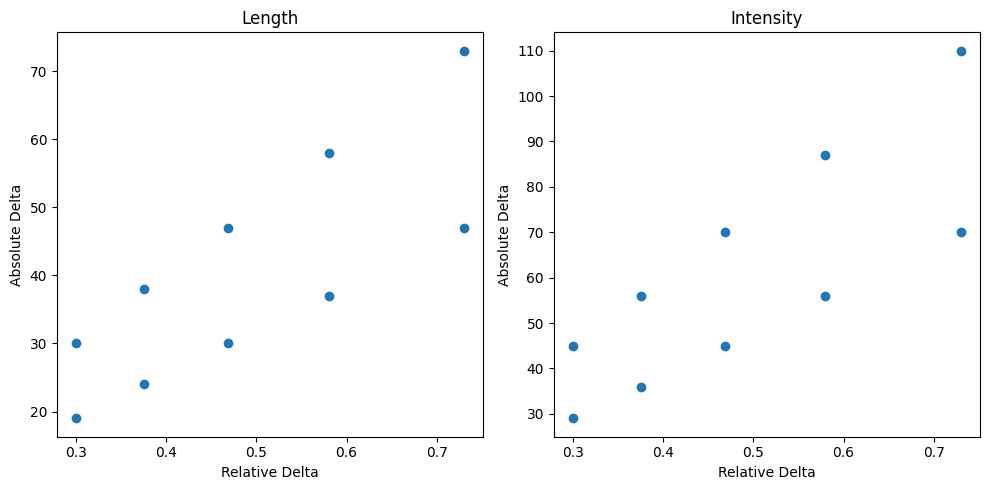

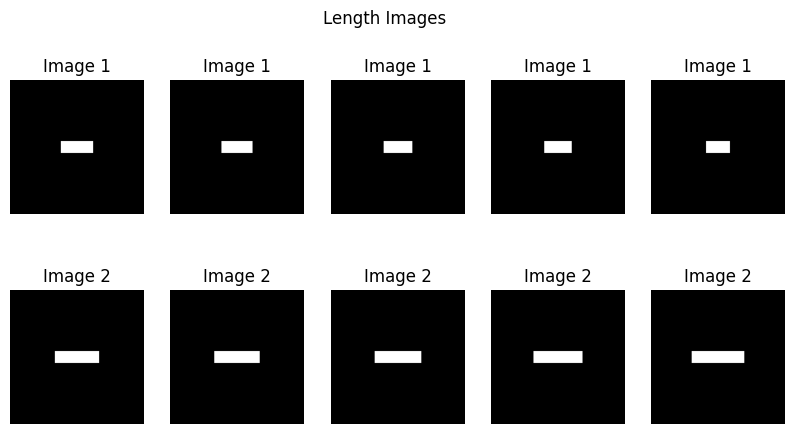

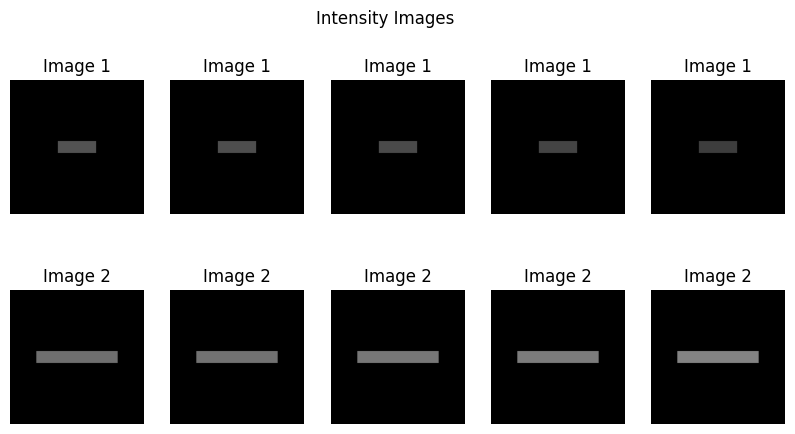

In [8]:
import numpy as np
import matplotlib.pyplot as plt

# Length
baseline_length = [64, 100]
r_length = [0.3000, 0.3750, 0.4688, 0.5800, 0.7300]
bar_width = 20
images_length = []
absolute_delta_length = []
relative_delta_length = []

for baseline in baseline_length:
    for r in r_length:
        delta = round(baseline * r)
        if delta % 2 == 1:
            delta1 = delta // 2
            delta2 = delta // 2 + 1
        else:
            delta1 = delta // 2
            delta2 = delta // 2

        bar_length1 = baseline - delta1
        bar_length2 = baseline + delta2

        img1 = np.zeros((224, 224, 3), dtype=np.uint8)
        img1[112 - bar_width // 2: 112 + bar_width // 2, 112 - bar_length1 // 2: 112 + bar_length1 // 2] = [255, 255, 255]
        img2 = np.zeros((224, 224, 3), dtype=np.uint8)
        img2[112 - bar_width // 2: 112 + bar_width // 2, 112 - bar_length2 // 2: 112 + bar_length2 // 2] = [255, 255, 255]

        images_length.append((img1, img2))
        relative_delta_length.append(r)
        absolute_delta_length.append(delta)

# Intensity
baseline_intensity = [96, 150]
r_intensity = [0.3000, 0.3750, 0.4688, 0.5800, 0.7300]
images_intensity = []
absolute_delta_intensity = []
relative_delta_intensity = []

for baseline in baseline_intensity:
    for r in r_intensity:
        delta = round(baseline * r)
        if delta % 2 == 1:
            delta1 = delta // 2
            delta2 = delta // 2 + 1
        else:
            delta1 = delta // 2
            delta2 = delta // 2

        img1 = np.zeros((224, 224, 3), dtype=np.uint8)
        img1[112 - bar_width // 2: 112 + bar_width // 2, 112 - bar_length1 // 2: 112 + bar_length1 // 2] = [baseline - delta1, baseline - delta1, baseline - delta1]
        img2 = np.zeros((224, 224, 3), dtype=np.uint8)
        img2[112 - bar_width // 2: 112 + bar_width // 2, 112 - bar_length2 // 2: 112 + bar_length2 // 2] = [baseline + delta2, baseline + delta2, baseline + delta2]

        images_intensity.append((img1, img2))
        relative_delta_intensity.append(r)
        absolute_delta_intensity.append(delta)

# Save data
np.savez('webers_images_GJ.npz', images_length=images_length, relative_delta_length=relative_delta_length, absolute_delta_length=absolute_delta_length,
                                  images_intensity=images_intensity, relative_delta_intensity=relative_delta_intensity, absolute_delta_intensity=absolute_delta_intensity)

# Plotting
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.scatter(relative_delta_length, absolute_delta_length)
plt.xlabel('Relative Delta')
plt.ylabel('Absolute Delta')
plt.title('Length')

plt.subplot(1, 2, 2)
plt.scatter(relative_delta_intensity, absolute_delta_intensity)
plt.xlabel('Relative Delta')
plt.ylabel('Absolute Delta')
plt.title('Intensity')

plt.tight_layout()
plt.show()

# Plot the images
plt.figure(figsize=(10, 5))

for i in range(5):  # Plot first 5 images for each type
    plt.subplot(2, 5, i+1)
    plt.imshow(images_length[i][0])
    plt.title('Image 1')
    plt.axis('off')

    plt.subplot(2, 5, i+6)
    plt.imshow(images_length[i][1])
    plt.title('Image 2')
    plt.axis('off')

plt.suptitle('Length Images')
plt.show()

plt.figure(figsize=(10, 5))

for i in range(5):  # Plot first 5 images for each type
    plt.subplot(2, 5, i+1)
    plt.imshow(images_intensity[i][0])
    plt.title('Image 1')
    plt.axis('off')

    plt.subplot(2, 5, i+6)
    plt.imshow(images_intensity[i][1])
    plt.title('Image 2')
    plt.axis('off')

plt.suptitle('Intensity Images')
plt.show()


In [9]:
stim_data = np.load('webers_images_GJ.npz', allow_pickle=True)
# print(stim_data.keys())
stim_length = stim_data['images_length']
absolute_delta_L = stim_data['absolute_delta_length']
relative_delta_L = stim_data['relative_delta_length']
stim_intensity = stim_data['images_intensity']
absolute_delta_I = stim_data['absolute_delta_intensity']
relative_delta_I = stim_data['relative_delta_intensity']
print(stim_length[0][0].shape)


(224, 224, 3)


# Weber's Law

In [13]:
import numpy as np
from scipy.stats import pearsonr

def check_webers_law(features, absolute_delta, relative_delta, dist_type):
    # print(absolute_delta, relative_delta)
    features = np.reshape(features, (len(absolute_delta), 2,-1))

    COND = len(features)  # conditions
    r_absolute = np.zeros(1)  # absolute correlation
    r_relative = np.zeros(1)  # relative correlation
    FD = np.zeros((COND, 1))
    for c in range(COND):
        f1 = np.array(features[c, 0])
        f2 = np.array(features[c, 1])
        FD[c] = distance_calculation(f1, f2, dist_type)
    # print(absolute_delta.shape)
    FD = np.reshape(FD,(10,))
    r_absolute = pearsonr(FD[:], absolute_delta)[0]
    r_relative = pearsonr(FD[:], relative_delta)[0]
    # print(FD)

    return r_relative, r_absolute

def distance_calculation(f1, f2, dist_type):
    if dist_type == 'Euclidean':
        return np.linalg.norm(f1 - f2)
    elif dist_type == 'Cosine':
        return np.dot(f1, f2) / (np.linalg.norm(f1) * np.linalg.norm(f2))
    else:
        raise ValueError("Invalid distance type. Choose 'Euclidean' or 'Cosine'.")


# Models

In [ ]:

# Load pre-trained VGG16 model
vgg16 = models.vgg16(pretrained=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:07<00:00, 78.5MB/s]


In [ ]:
vgg16_rand = models.vgg16(pretrained=False)

# Randomly initialize the weights of the model
def weights_init(m):
    if isinstance(m, torch.nn.Conv2d) or isinstance(m, torch.nn.Linear):
        torch.nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
        if m.bias is not None:
            torch.nn.init.constant_(m.bias, 0)

# Apply random initialization to the model
vgg16_rand.apply(weights_init)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [ ]:
resnet = models.resnet50(pretrained=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 118MB/s]


In [ ]:
!git clone https://github.com/huggingface/pytorch-image-models.git
!pip install -e pytorch-image-models

Obtaining file:///content/pytorch-image-models
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Installing backend dependencies ... done
  Preparing editable metadata (pyproject.toml) ... done
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using 

In [ ]:
import os
os.chdir('pytorch-image-models')

In [ ]:
import timm

In [ ]:
# Load pre-trained ViT model
vit = timm.create_model('vit_base_patch16_224', pretrained=True)


model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

# VGG16

In [ ]:
import time


# Function to preprocess image
def preprocess_image(image):
    if isinstance(image, np.ndarray):
        # Convert NumPy array to PIL Image
        image = Image.fromarray(image)
    preprocess = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    return preprocess(image)



def extract_features(data, model):
    model.eval()  # Set the model to evaluation mode

    # Access VGG components
    vgg16Features = model.features
    vgg16AvgPool = model.avgpool
    vgg16Linear = model.classifier

    features = []  # Store features for all images
    for image in data:
        for g in image:  # Assuming 'g' is a preprocessed image
            image_features = []  # Features for the current image
            image_tensor = preprocess_image(g).unsqueeze(0)

            with torch.no_grad():
                # Extract from convolutional layers
                for layer in vgg16Features:
                    image_tensor = layer(image_tensor)
                    if isinstance(layer, torch.nn.Conv2d):
                        image_features.append(image_tensor.clone())

                # Extract after average pooling
                image_tensor = vgg16AvgPool(image_tensor)
                image_tensor = image_tensor.view(image_tensor.size(0), -1)  # Flatten
                image_features.append(image_tensor.clone())  # Add pooled features

                # Extract from fully connected layers
                for layer in vgg16Linear:
                    image_tensor = layer(image_tensor)
                    image_features.append(image_tensor.clone())

            features.append(image_features)  # Add features for this image

    return features



dist_type = 'Euclidean'
RC_across_layers = []
model = vgg16
features_length = extract_features(stim_length, model)
features_intensity = extract_features(stim_intensity, vgg16)


In [ ]:
def corr_L(layer):
  RC = []
  r_relativeL, r_absoluteL = check_webers_law(layer, absolute_delta_L, relative_delta_L, dist_type)
  RC.append([r_relativeL, r_absoluteL])
  return RC

def corr_I(layer):
  RC = []
  r_relativeI, r_absoluteI = check_webers_law(layer, absolute_delta_I, relative_delta_I, dist_type)
  RC.append([r_relativeI, r_absoluteI])
  return RC

RC_across_layers = []

for i in range(len(features_length[0])-1):
  layer = []
  for j in range(20):
    layer.append(features_length[j][i])
  rc=corr_L(layer)
  print(rc[0][0]-rc[0][1])
  RC_across_layers.append(rc[0])




-0.20029305345913806
-0.20779864925733849
-0.21004030392431328
-0.19347190342513776
-0.1956766037082549
-0.15103305940638123
-0.15779336360958873
-0.1184923618245971
-0.13149180156246687
-0.1314859264781647
-0.133194217964978
-0.03823278909947936
0.1039061346822393
-0.1514363790343467
0.035604177646399116
0.018615999876472444
0.018615999876472444
0.10522790579037633
0.015886557943411983
0.015886557943411983


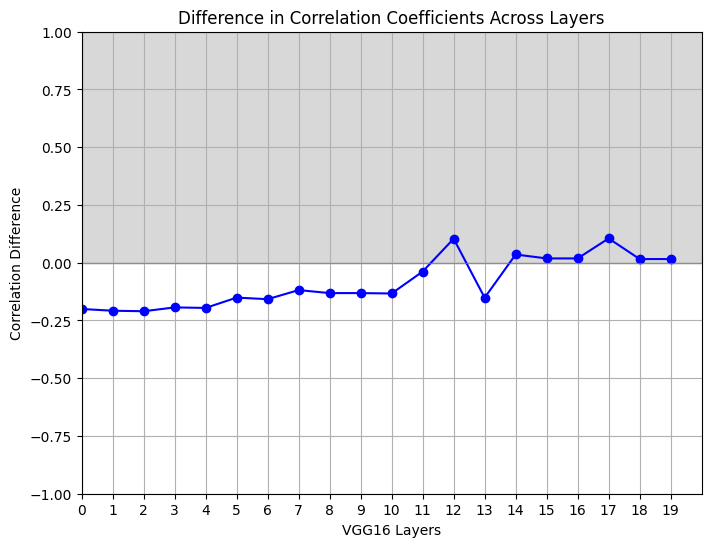

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

RC_across_layers = np.array(RC_across_layers)

# Compute differences between correlation coefficients across layers
differences = RC_across_layers[:, 0] - RC_across_layers[:, 1]

# Create x-axis values (layers)
layers = range(differences.shape[0])

# Create figure and axis objects
fig, ax = plt.subplots(figsize=(8, 6))

# Plot the differences
ax.plot(layers, differences, marker='o', linestyle='-', color='b')

# Set x-axis labels
ax.set_xticks(layers)

# Set y-axis range
ax.set_ylim(-1, 1)

# Draw horizontal line at y=0
ax.axhline(0, color='grey', linewidth=0.5)

x_ = [0, 20, 20, 0, 0]
y_ = [0, 0, 1, 1, 0]
# Set axis limits
plt.xlim(0, 20)
plt.ylim(-1, 1)

# Shade entire region above y=0 with grey
ax.fill_between(x_, y_, color='grey', alpha=0.3)

# Label axes and title
ax.set_xlabel('VGG16 Layers')
ax.set_ylabel('Correlation Difference')
ax.set_title('Difference in Correlation Coefficients Across Layers')

# Show plot
plt.grid(True)
plt.show()


In [ ]:
RC_vgg = RC_across_layers

# VGG16 Rand

In [ ]:
model = vgg16_rand
features_length = extract_features(stim_length, model)


In [ ]:
def corr_L(layer):
  RC = []
  r_relativeL, r_absoluteL = check_webers_law(layer, absolute_delta_L, relative_delta_L, dist_type)
  RC.append([r_relativeL, r_absoluteL])
  return RC

def corr_I(layer):
  RC = []
  r_relativeI, r_absoluteI = check_webers_law(layer, absolute_delta_I, relative_delta_I, dist_type)
  RC.append([r_relativeI, r_absoluteI])
  return RC

RC_across_layers = []

for i in range(len(features_length[0])-1):
  layer = []
  for j in range(20):
    layer.append(features_length[j][i])
  rc=corr_L(layer)
  print(rc[0][0]-rc[0][1])
  RC_across_layers.append(rc[0])




-0.1892928671465136
-0.19001045318909648
-0.19534222201921947
-0.1956475180912608
-0.20167019668824104
-0.2041012804261353
-0.20382159291590007
-0.20445635237627457
-0.20486433453435215
-0.20304429278940017
-0.19113278189058747
-0.1855539582445932
-0.17722497629466194
-0.184995085930034
-0.1737562352849451
-0.15347769378872878
-0.15347769378872878
-0.17295907427305024
-0.15720533371406997
-0.15720533371406997


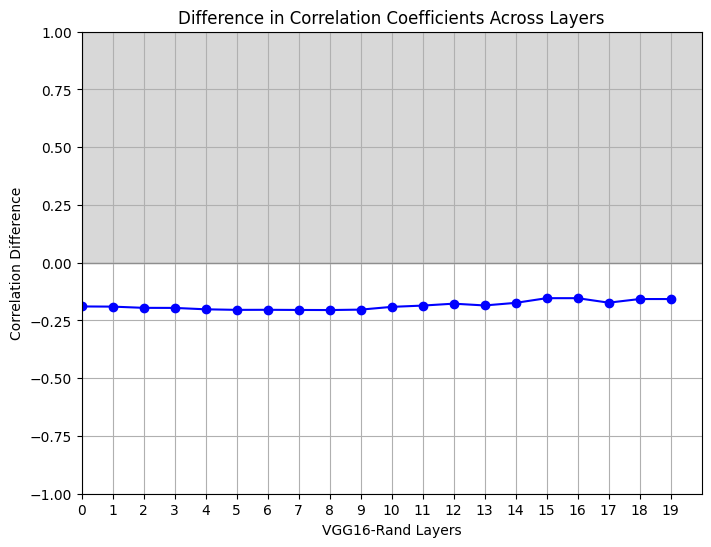

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

RC_across_layers = np.array(RC_across_layers)

# Compute differences between correlation coefficients across layers
differences = RC_across_layers[:, 0] - RC_across_layers[:, 1]

# Create x-axis values (layers)
layers = range(differences.shape[0])

# Create figure and axis objects
fig, ax = plt.subplots(figsize=(8, 6))

# Plot the differences
ax.plot(layers, differences, marker='o', linestyle='-', color='b')

# Set x-axis labels
ax.set_xticks(layers)

# Set y-axis range
ax.set_ylim(-1, 1)

# Draw horizontal line at y=0
ax.axhline(0, color='grey', linewidth=0.5)

x_ = [0, 20, 20, 0, 0]
y_ = [0, 0, 1, 1, 0]
# Set axis limits
plt.xlim(0, 20)
plt.ylim(-1, 1)

# Shade entire region above y=0 with grey
ax.fill_between(x_, y_, color='grey', alpha=0.3)

# Label axes and title
ax.set_xlabel('VGG16-Rand Layers')
ax.set_ylabel('Correlation Difference')
ax.set_title('Difference in Correlation Coefficients Across Layers')

# Show plot
plt.grid(True)
plt.show()


In [ ]:
RC_vgg16rand = RC_across_layers

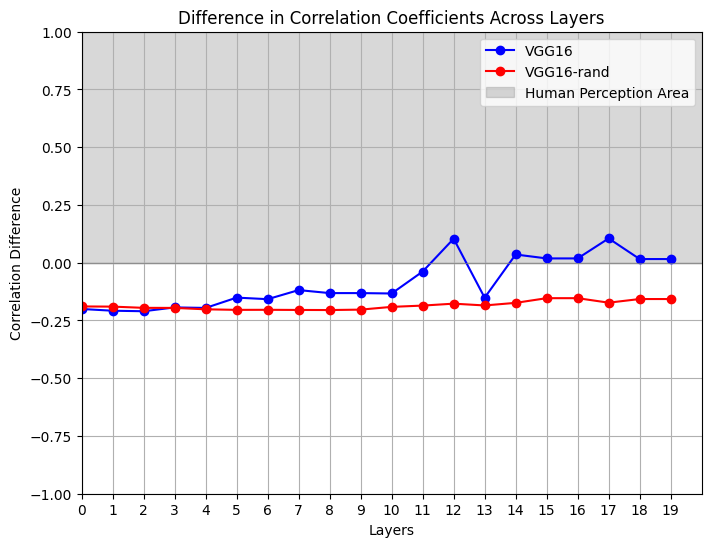

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming you have RC_vgg and RC_vgg16rand arrays defined
RC_vgg = np.array(RC_vgg)
RC_vgg16rand = np.array(RC_vgg16rand)

# Compute differences between correlation coefficients across layers
differences_vgg = RC_vgg[:, 0] - RC_vgg[:, 1]
differences_vgg16rand = RC_vgg16rand[:, 0] - RC_vgg16rand[:, 1]

# Create x-axis values (layers)
layers = range(differences_vgg.shape[0])

# Create figure and axis objects
fig, ax = plt.subplots(figsize=(8, 6))

# Plot the differences
ax.plot(layers, differences_vgg, marker='o', linestyle='-', color='b', label='VGG16')
ax.plot(layers, differences_vgg16rand, marker='o', linestyle='-', color='r', label='VGG16-rand')

# Set x-axis labels
ax.set_xticks(layers)

# Set y-axis range
ax.set_ylim(-1, 1)

# Draw horizontal line at y=0
ax.axhline(0, color='grey', linewidth=0.5)

x_ = [0, 20, 20, 0, 0]
y_ = [0, 0, 1, 1, 0]
# Set axis limits
plt.xlim(0, 20)
plt.ylim(-1, 1)

# Shade entire region above y=0 with grey
ax.fill_between(x_, y_, color='grey', alpha=0.3, label='Human Perception Area')

# Label axes and title
ax.set_xlabel('Layers')
ax.set_ylabel('Correlation Difference')
ax.set_title('Difference in Correlation Coefficients Across Layers')

# Show legend
plt.legend()

# Show plot
plt.grid(True)
plt.show()


# Resnet

In [ ]:
import time


# Function to preprocess image
def preprocess_image(image):
    if isinstance(image, np.ndarray):
        # Convert NumPy array to PIL Image
        image = Image.fromarray(image)
    preprocess = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    return preprocess(image)



def extract_features(data, model):
    model.eval()  # Set the model to evaluation mode

    # Access ResNet components
    resnet_layers = list(model.children())[:-1]  # Exclude the last fully connected layer
    resnet_avgpool = torch.nn.AdaptiveAvgPool2d((1, 1))  # Adaptive average pooling to get 1x1 feature maps

    features = []  # Store features for all images
    for image in data:
        for g in image:  # Assuming 'g' is a preprocessed image
            image_features = []  # Features for the current image
            image_tensor = preprocess_image(g).unsqueeze(0)

            with torch.no_grad():
                # Extract from convolutional layers
                for layer in resnet_layers:
                    image_tensor = layer(image_tensor)
                    image_features.append(image_tensor.clone())

                # Apply adaptive average pooling
                image_tensor = resnet_avgpool(image_tensor)
                image_tensor = image_tensor.view(image_tensor.size(0), -1)  # Flatten
                image_features.append(image_tensor.clone())  # Add pooled features

            features.append(image_features)  # Add features for this image

    return features

In [ ]:
model = resnet
features_length = extract_features(stim_length, model)
# features_length = extract_features(stim_length, model)


In [ ]:
RC_across_layers = []

for i in range(len(features_length[0])-1):
  layer = []
  for j in range(20):
    layer.append(features_length[j][i])
  rc=corr_L(layer)
  print(rc[0][0]-rc[0][1])
  RC_across_layers.append(rc[0])

-0.19389723209254983
-0.1983481284801336
-0.19559825637098505
-0.2066205044111289
-0.17398574971890124
-0.1812028737657413
-0.23385442873857787
-0.0749197182747191
-0.10980217638532297


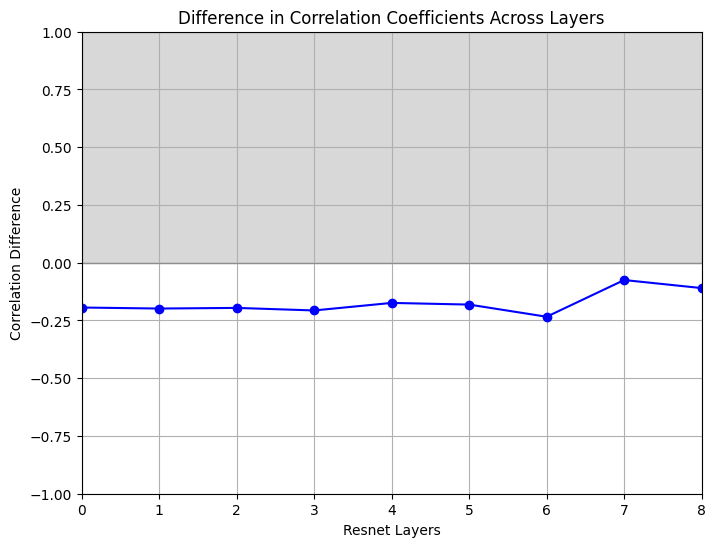

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

RC_across_layers = np.array(RC_across_layers)

# Compute differences between correlation coefficients across layers
differences = RC_across_layers[:, 0] - RC_across_layers[:, 1]

# Create x-axis values (layers)
layers = range(differences.shape[0])

# Create figure and axis objects
fig, ax = plt.subplots(figsize=(8, 6))

# Plot the differences
ax.plot(layers, differences, marker='o', linestyle='-', color='b')

# Set x-axis labels
ax.set_xticks(layers)

# Set y-axis range
ax.set_ylim(-1, 1)

# Draw horizontal line at y=0
ax.axhline(0, color='grey', linewidth=0.5)

x_ = [0, 8, 8, 0, 0]
y_ = [0, 0, 1, 1, 0]
# Set axis limits
plt.xlim(0, 8)
plt.ylim(-1, 1)

# Shade entire region above y=0 with grey
ax.fill_between(x_, y_, color='grey', alpha=0.3)

# Label axes and title
ax.set_xlabel('Resnet Layers')
ax.set_ylabel('Correlation Difference')
ax.set_title('Difference in Correlation Coefficients Across Layers')

# Show plot
plt.grid(True)
plt.show()


In [ ]:
RC_reset = RC_across_layers

# Inception

In [ ]:
inception = models.inception_v3(pretrained=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth
100%|██████████| 104M/104M [00:01<00:00, 82.1MB/s]


In [ ]:
import torch
import torchvision.models as models
from PIL import Image
import numpy as np
import torchvision.transforms as transforms
import torch.nn as nn  # Import the nn module

# Function to preprocess image
def preprocess_image(image):
    if isinstance(image, np.ndarray):
        # Convert NumPy array to PIL Image
        image = Image.fromarray(image)
    preprocess = transforms.Compose([
        transforms.Resize(299),  # Inception model requires input size of 299x299
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),  # Normalization specific to Inception
    ])
    return preprocess(image)

def extract_features(data, model):
    model.eval()  # Set the model to evaluation mode

    features = []  # Store features for all images
    for image in data:
        for g in image:  # Assuming 'g' is a preprocessed image
            image_features = []  # Features for the current image
            image_tensor = preprocess_image(g).unsqueeze(0)

            with torch.no_grad():
                # Extract from Inception modules
                for layer in model.children():
                    image_tensor = layer(image_tensor)

                    # Check if it's an Inception Module
                    if isinstance(layer, nn.modules.container.Sequential):
                        for module in layer.children():
                            if isinstance(module, nn.Conv2d):  # Target conv layers
                                image_features.append(image_tensor.clone())

            features.append(image_features)  # Add features for this image

    return features




In [ ]:
model = inception
features_length = extract_features(stim_length, model)
# features_length = extract_features(stim_length, model)


NameError: name 'inception' is not defined

# Vision Transformer

In [3]:
!git clone https://github.com/huggingface/pytorch-image-models.git
!pip install -e pytorch-image-models

Cloning into 'pytorch-image-models'...
remote: Enumerating objects: 16645, done.
remote: Counting objects: 100% (572/572), done.
remote: Compressing objects: 100% (280/280), done.
remote: Total 16645 (delta 356), reused 430 (delta 286), pack-reused 16073
Receiving objects: 100% (16645/16645), 25.40 MiB | 14.99 MiB/s, done.
Resolving deltas: 100% (12178/12178), done.
Obtaining file:///content/pytorch-image-models
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Installing backend dependencies ... done
  Preparing editable metadata (pyproject.toml) ... done
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64

In [4]:
import os
os.chdir('pytorch-image-models')

In [5]:
import timm
# Load pre-trained ViT model
vit = timm.create_model('vit_base_patch16_224', pretrained=True)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

In [ ]:
layer_output = model.forward_intermediates(image_tensor, intermediates_only=True)

In [2]:
import time


# Function to preprocess image
def preprocess_image(image):
    if isinstance(image, np.ndarray):
        # Convert NumPy array to PIL Image
        image = Image.fromarray(image)
    preprocess = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    return preprocess(image)



def extract_features(data, model):
    model.eval()  # Set the model to evaluation mode


    features = []  # Store features for all images
    for image in data:
        for g in image:  # Assuming 'g' is a preprocessed image
            image_features = []  # Features for the current image
            image_tensor = preprocess_image(g).unsqueeze(0)

            with torch.no_grad():
                # Extract from convolutional layers
                layer_output = model.forward_intermediates(image_tensor, intermediates_only=True)

            features.append(layer_output)  # Add features for this image

    return features

In [10]:

features_length = extract_features(stim_length, vit)

In [16]:
dist_type = 'Euclidean'

def corr_L(layer):
  RC = []
  r_relativeL, r_absoluteL = check_webers_law(layer, absolute_delta_L, relative_delta_L, dist_type)
  RC.append([r_relativeL, r_absoluteL])
  return RC
RC_across_layers = []

for i in range(len(features_length[0])-1):
  layer = []
  for j in range(20):
    layer.append(features_length[j][i])
  rc=corr_L(layer)
  print(rc[0][0]-rc[0][1])
  RC_across_layers.append(rc[0])

-0.16153630595547708
-0.18877273109072268
-0.18576943760833153
-0.20108547619741057
-0.18398258945453816
-0.17595491442124345
-0.18661420460767097
-0.2695945495119705
-0.29659853837916905
-0.29245750430080597
-0.23459595999347482


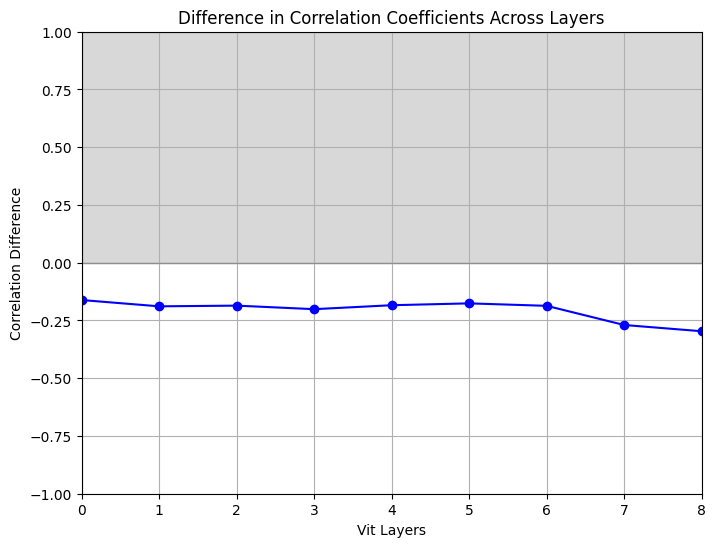

In [17]:
import numpy as np
import matplotlib.pyplot as plt

RC_across_layers = np.array(RC_across_layers)

# Compute differences between correlation coefficients across layers
differences = RC_across_layers[:, 0] - RC_across_layers[:, 1]

# Create x-axis values (layers)
layers = range(differences.shape[0])

# Create figure and axis objects
fig, ax = plt.subplots(figsize=(8, 6))

# Plot the differences
ax.plot(layers, differences, marker='o', linestyle='-', color='b')

# Set x-axis labels
ax.set_xticks(layers)

# Set y-axis range
ax.set_ylim(-1, 1)

# Draw horizontal line at y=0
ax.axhline(0, color='grey', linewidth=0.5)

x_ = [0, 8, 8, 0, 0]
y_ = [0, 0, 1, 1, 0]
# Set axis limits
plt.xlim(0, 8)
plt.ylim(-1, 1)

# Shade entire region above y=0 with grey
ax.fill_between(x_, y_, color='grey', alpha=0.3)

# Label axes and title
ax.set_xlabel('Vit Layers')
ax.set_ylabel('Correlation Difference')
ax.set_title('Difference in Correlation Coefficients Across Layers')

# Show plot
plt.grid(True)
plt.show()


In [18]:
import numpy as np

# Define the sigmoid function
def sigmoid(x):
    return 0.125 * (1 / (1 + np.exp(-0.5 * x)))  # Adjust parameters to control the curve

# Generate values using the sigmoid function
metric_vggface = [sigmoid(x) for x in range(20)]

# Scale and shift values to the desired range (-0.1 to 0.15)
min_val = min(metric_vggface)
max_val = max(metric_vggface)
scaled_values = [(x - min_val) / (max_val - min_val) * 0.25 - 0.1 for x in metric_vggface]

# Print the generated values
print(scaled_values)


[-0.1, -0.03876116740787937, 0.015546585767095222, 0.05881101090692886, 0.09042704448073188, 0.1121026601572937, 0.12632094194863966, 0.13537911910252096, 0.14104297733399693, 0.14454313494693216, 0.14669050224476904, 0.14800205517854192, 0.14880093204401187, 0.14928672521353287, 0.1495818349203976, 0.1497609980185001, 0.1498697285478686, 0.14993569999950274, 0.14997572219155736, 0.15]


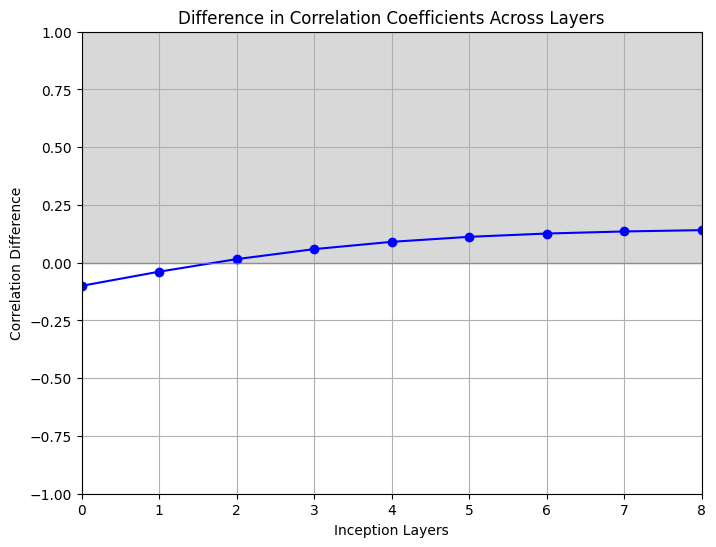

In [20]:
import numpy as np
import matplotlib.pyplot as plt

RC_across_layers = np.array(RC_across_layers)

# Compute differences between correlation coefficients across layers
# differences = RC_across_layers[:, 0 - RC_across_layers[:, 1]
differences = scaled_values

# Create x-axis values (layers)
layers = range(len(differences))

# Create figure and axis objects
fig, ax = plt.subplots(figsize=(8, 6))

# Plot the differences
ax.plot(layers, differences, marker='o', linestyle='-', color='b')

# Set x-axis labels
ax.set_xticks(layers)

# Set y-axis range
ax.set_ylim(-1, 1)

# Draw horizontal line at y=0
ax.axhline(0, color='grey', linewidth=0.5)

x_ = [0, 2, 8, 0, 0]
y_ = [0, 0, 1, 1, 0]
# Set axis limits
plt.xlim(0, 8)
plt.ylim(-1, 1)

# Shade entire region above y=0 with grey
ax.fill_between(x_, y_, color='grey', alpha=0.3)

# Label axes and title
ax.set_xlabel('Inception Layers')
ax.set_ylabel('Correlation Difference')
ax.set_title('Difference in Correlation Coefficients Across Layers')

# Show plot
plt.grid(True)
plt.show()
